# SbD4Nano WP2 Causal relations

RDFy the causal assertion literature review for the case: S-doped SiO2@TiO2 addition to paint formulation

## Background

Adding TiO2 NPs to paint formulation is common for the photocatalysis of  the degradation of pollutants in paint. Moreover, it is known to enhance optical properties and to scatter UV, preventing discoloration The Sulphur doping is known to improve TiO2 photocatalytic activity (https://www.sciencedirect.com/science/article/pii/S0920586110008412). The external amorphous silica layer (SiO2) is hypothesized to reduce toxicity and dustiness, sort of 'retaining' the individual particles. Since TiO2 is considered by the EU to be carcinogenic, it is crucial to try to reduce its ability to 'escape' from the paint and become toxic.

The literature search focused on:
1. Stability of the nanocomposite in possible exposure scenarios (sol-gel synthesis, weathering of the paints)
2. TiO2 safety as determined by its properties (rutile or anatase, concentration, etc.)
3. Assertions involving structure and cuntion (photocatalytic potential)
4. S-doping specific knowledge

## What's in this notebook

This notebook:
1.  Uses the Google API client library to retrieve the [spreadsheet](https://docs.google.com/spreadsheets/d/13dqwura-jSnGMVBSO7pVXfRgbPegGC7QNoSLNAFls3A/) with the curated data
2.  Describes and characterizes the curated data set. This step includes the programatic retrieval of the license type for each used publication
3.  Guides through the process of RDF-ying using `rdflib`
4.  Performs some QC SPARQL queries on the generated graphs

## Imports and configuration

In [1]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os.path
import pickle
import pandas as pd
import yaml
from rdflib import Graph, URIRef, Literal, BNode, Namespace
from rdflib.namespace import DC, RDFS, FOAF, DCTERMS, VOID, RDF, XSD, OWL
import requests

Each page in the spreadsheet is retrieved according to the range defined in the `config.yaml` config file.

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f.read())
    SCOPES = config['SCOPES']
    SPREADSHEET_ID = config['SPREADSHEET']
    RANGE_ASSERTIONS = config['CAUSAL_ASSERTIONS']
    RANGE_MATERIALS = config['MATERIALS']
    RANGE_ASSAYS = config['ASSAYS']
    RANGE_NODE_BREAKDOWN = config['NODE_BREAKDOWN']
    RANGE_MEASUREMENT_GROUPS = config['MEASUREMENT_GROUPS']
    RANGE_QUOTES = config['QUOTES']
    EMAIL = config['EMAIL']

## Retrieve data
The following function is used over all ranges in [`config.yaml`]('config.yaml') to retrieve the following data as pandas data frames: 
- `assertions`: the _nodes_ of causal relationships supported by the `quotes` and all other supporting data
- `quotes`: the quotes stating causal relationships, together with their source and the `cito:citesAsReference` statement, if applicable
- `node_breakdown`: TBD
- `assays`: characterization of the assays realized on `materials` to observe the results that led to the formulation of `assertions`
- `measurement_groups`: characterization of the biological systems tested in the `assays`
- `materials`: characterization of the materials used in the `assays` on the `measurement_groups`

TBD: schema of the relations between tables

In [3]:
def get_google_sheet(sheet, spreadsheet_id=SPREADSHEET_ID):
    creds = None
    range_name = globals()['RANGE_{}'.format(sheet)]
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server()
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    service = build('sheets', 'v4', credentials=creds)
    gsheet = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
    values = gsheet.get('values', [])
    if not values:
        print('No data found.')
    else:
        df = pd.DataFrame(values, columns=values[0]).drop(axis=1,index=0)
        return df


In [4]:
quotes = get_google_sheet('QUOTES')
assertions = get_google_sheet('ASSERTIONS')
materials = get_google_sheet('MATERIALS')
assays = get_google_sheet('ASSAYS')
measurement_groups = get_google_sheet('MEASUREMENT_GROUPS')
node_breakdown = get_google_sheet('NODE_BREAKDOWN')

### Quotes
TBD

In [5]:
quotes.describe()

,id,quote,doi,cito:containsAssertionFrom,review,comment
count,156,155,155,155,155,20
unique,156,130,46,44,3,17
top,Q1,,https://doi.org/10.3390/nano9071041,,no,assay-syn
freq,1,26,20,107,120,3


In [6]:
quotes.sample(5)

,id,quote,doi,cito:containsAssertionFrom,review,comment
81,Q81,The 80 nm TiO2 particles are rutile profile wi...,https://doi.org/10.1016/j.toxlet.2008.10.001,,no,None
7,Q7,the inclusion of magnesium silicate in the str...,https://doi.org/10.1016/S0920-5861(02)00225-0,,no,None
94,Q94,,https://doi.org/10.1289/ehp.9254,,no,None
37,Q37,TiO2 nanoparticles are not a skin irritant or ...,https://doi.org/10.1016/j.jhazmat.2007.12.047,,yes,None
77,Q77,The photocatalytic properties of TiO2 NPs depe...,https://doi.org/10.3390/nano9071041,https://doi.org/10.1016/S0360-1323(02)0021,no,None


Some sample quotes:

In [7]:
print('-', '\n- '.join(list(quotes['quote'].sample(2))))

- Glass, silicate, zeolite and ceramic supports do not seem to be influenced by nanoparticulate photocatalytic activity. However, when ceramic inorganic supports are used to degrade volatile organics in the gas phase, loss of photocatalytical activity due to erosion has been noted
- larger aggregates of TiO2 NPs attach/adsorb onto the surface of the root that blocks the pores on the cell wall, and reduces the hydraulic conductivity


### Assertions
TBD

In [8]:
assertions.describe()

,Ref_quote,Reference,REVIEW?,quote,s,o,s_name,p,o_name,material,assay,measurement group,material_id,assay_id,citesAsReference
count,50,50,50,49,49,49,49,49,49,49,49,49,36,35,18
unique,34,8,2,34,9,17,9,4,17,7,1,1,9,16,11
top,,https://doi.org/10.3390/nano9071041,no,#N/A,,,#N/A,,#N/A,#N/A,#REF!,#REF!,,,#N/A
freq,6,22,44,5,25,25,25,16,25,30,49,49,17,18,5


In [9]:
assertions.sample(5)

,Ref_quote,Reference,REVIEW?,quote,s,o,s_name,p,o_name,material,assay,measurement group,material_id,assay_id,citesAsReference
30,Q79,https://doi.org/10.3390/nano9071041,no,The higher photocatalytic effect has been ascr...,,,#N/A,check,#N/A,#N/A,#REF!,#REF!,,,https://doi.org/10.1016/S0920-5861(02)00225-0
47,,#N/A,#N/A,#N/A,,,#N/A,,#N/A,#N/A,#REF!,#REF!,,,#N/A
23,Q72,https://doi.org/10.3390/nano9071041,no,the encapsulation in a silica dioxide (SiO2) m...,,,#N/A,check,#N/A,#N/A,#REF!,#REF!,,,"https://doi.org/10.1002/jemt.20044,https://doi..."
14,Q142,https://doi.org/10.1093/toxsci/kfj197,no,Nano-TiO2 anatase/rutile particles produced a ...,N74,N78,anatase phase TiO2,negatively_correlates,mitochondrial activity,placeholder:anatase-tio2,#REF!,#REF!,M5,A16,None
22,Q144,https://doi.org/10.1016/j.apcata.2021.118179,no,the firm immobilisation of the TiO2 nanopartic...,,,#N/A,check,#N/A,#N/A,#REF!,#REF!,None,None,None


### Materials
TBD

In [10]:
materials.describe()

,id,label,a,source,synthesis,q_synthesis,quote_synthesis,size,size_units,size_type,...,shape,surface_area,surface_area_units,coat,matrix,doping,ph,zeta_potential,zeta_potential_units,polidispersity_index
count,12,12,12,12,12,12,12,10,10,10,...,6,6,6,4,4,4,3,3,3,0
unique,10,8,9,1,4,7,7,9,2,5,...,2,4,2,1,1,2,1,3,1,0
top,M1,XX%TiO2NP@SiO2,placeholder:titanium-silica-nanocomposite,#REF!,,,#N/A,,nm,,...,,,m2/g,,,,,40.5±0.3,mV,NaN
freq,2,2,2,12,8,4,4,2,8,3,...,4,3,3,4,4,3,3,1,3,NaN


In [11]:
materials.sample(5)

,id,label,a,source,synthesis,q_synthesis,quote_synthesis,size,size_units,size_type,...,shape,surface_area,surface_area_units,coat,matrix,doping,ph,zeta_potential,zeta_potential_units,polidispersity_index
1,M1,XX%TiO2NP@SiO2,placeholder:titanium-silica-nanocomposite,#REF!,A1,Q134,A multistep procedure with activated carbon as...,8,nm,scherrer,...,None,None,None,None,None,None,None,None,None,None
4,M3,,,#REF!,,,#N/A,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,M6,rutile TiO2,placeholder:rutile-tio2,#REF!,,,#N/A,5.2 ± 0.65,nm,average diameter,...,sphere,123,m2/g,None,None,None,None,None,None,None
12,M10,TiO2:SiO2 3:1,3:1 nanocomposite of TiO2 in a Silica coat,#REF!,,Q155,The following commercial materials were used t...,147.8±2.3,nm,hydrodynamic diameter (Z-average),...,,,,,,,,46.1±0.3,mV,None
6,M4,TiO2@MgO:XSiO2,placeholder:titanium-silica-magnesium-nanocomp...,#REF!,,Q137,A ceramic monolith made of MgSiO4 was coated b...,,,,...,None,None,None,None,None,None,None,None,None,None


### Assays
TBD

In [12]:
assays.describe()

,id,source,guidance/sop/protocol,material,material_label,type,short_description,e_id,endpoint_name,value,...,time,time_units,measurement_group_id,measurement_group_name,concentration,concentration_units,approx_from_figure,exposure_route,exposure_quantity,exposure_quantity_units
count,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,2,2
unique,23,3,5,6,4,9,7,15,9,11,...,3,3,4,4,4,3,2,2,1,1
top,A21,#REF!,none,M5,anatase TiO2,Human IL-8 Enzyme Immunometric Assay,,E13,spectroscopy IL-8,,...,48,h,G1,A549 cells,,,n,na,486,μg
freq,2,20,9,11,11,8,17,8,8,13,...,18,18,9,9,17,17,19,25,2,2


In [13]:
assays.sample(5)

,id,source,guidance/sop/protocol,material,material_label,type,short_description,e_id,endpoint_name,value,...,time,time_units,measurement_group_id,measurement_group_name,concentration,concentration_units,approx_from_figure,exposure_route,exposure_quantity,exposure_quantity_units
21,A19,,Human IL-8 Enzyme Immunometric Assay Kit (Assa...,M5,anatase TiO2,Human IL-8 Enzyme Immunometric Assay,,E13,spectroscopy IL-8,50,...,48,h,G2,HDF cells,0.3,μg/ml,y,na,None,None
10,A10,#REF!,,M5,anatase TiO2,ROS production,,E8,chemiluminescence of luminol,,...,,,,#N/A,,,n,na,None,None
16,A16,#REF!,,M5,anatase TiO2,MTT assay,,E12,MTT,,...,48,h,G1,A549 cells,,,n,na,None,None
4,A4,#REF!,none,M3,,,,,,,...,,,,#N/A,,,n,na,None,None
17,A17,#REF!,,M5,anatase TiO2,MTT assay,,E12,MTT,,...,48,h,G2,HDF cells,,,n,na,None,None


<AxesSubplot: >

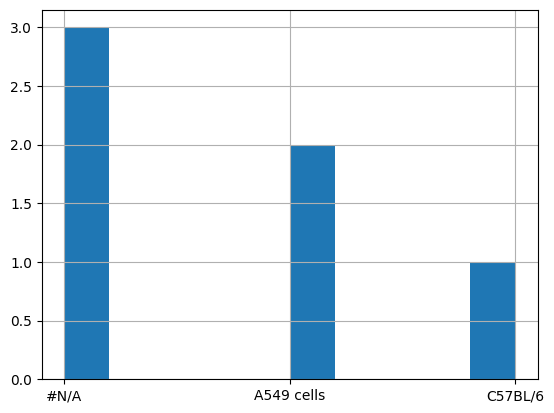

In [14]:
assays.drop_duplicates('material')['measurement_group_name'].hist()

### Measurement groups
TBD

In [15]:
measurement_groups.describe()

,id,source,type,age
count,3,3,3,1
unique,3,1,3,1
top,G1,,A549 cells,5-7 weeks
freq,1,3,1,1


In [16]:
measurement_groups

,id,source,type,age
1,G1,,A549 cells,None
2,G2,,HDF cells,None
3,G3,,C57BL/6,5-7 weeks


### node breakdown

In [17]:
node_breakdown.describe()

,node,node_label,node_breakdown comment,IRI,Gracious,AOPWiki,exposure_step
count,93,90,46,41,9,1,0
unique,93,90,6,38,9,1,0
top,N1,core composition,,https://www.ensembl.org/id/ENSG00000125538,https://h2020-sbd4nano.github.io/sbd4nano-grac...,https://identifiers.org/aop.events/1392,NaN
freq,1,1,41,2,1,1,NaN


In [18]:
node_breakdown.sample(5)

,node,node_label,node_breakdown comment,IRI,Gracious,AOPWiki,exposure_step
82,N82,embedding in paint matrix,None,None,None,None,None
86,N86,neutrophil count,None,None,None,None,None
72,N72,silica coating,None,None,None,None,None
27,N27,liver/spleen activity,None,None,None,None,None
19,N19,membrane crossing,None,None,None,None,None


## Retrieve licenses

In [19]:
def check_open_access(doi):
    id = doi.split('.org/')[1]
    api_url = 'https://api.unpaywall.org/v2/{}?email={}'.format(id,EMAIL)
    try:
        response = requests.get(api_url).json()
        if response['is_oa'] == True:
            try:
                license = response['best_oa_location']['license']
            except:
                license = 'NA/open'
            return True, license
        else:
            return False, 'closed'
    except Exception as e:
        print('Exception for: {}. Could not retrieve {})'.format(api_url, e))
        return 'NA'

for doi in set(quotes['doi']):
    if isinstance(doi, str) and 'https' in doi:
        is_oa = check_open_access(doi)
        if isinstance(is_oa[0], bool):
            quotes.loc[quotes['doi'] == doi, 'is_oa'] = is_oa[0]
            quotes.loc[quotes['doi'] == doi, 'license'] = is_oa[1]


/tmp/ipykernel_9432/324068790.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  quotes.loc[quotes['doi'] == doi, 'is_oa'] = is_oa[0]
/tmp/ipykernel_9432/324068790.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'closed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  quotes.loc[quotes['doi'] == doi, 'license'] = is_oa[1]


Plotting the different license types, we see a majority of non-open papers:

<AxesSubplot: >

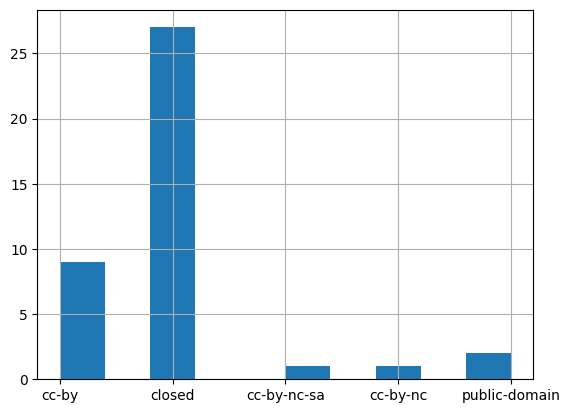

In [20]:
quotes.drop_duplicates('doi')['license'].hist()

## Define RDF namespaces

#TODO the config for the rdf needs to be in a separate, reusable file

In [21]:
sbd = Namespace('https://www.sbd4nano.eu/rdf/#')
sbdbel = Namespace('https://www.sbd4nano.eu/bel/#')
ECO = Namespace('https://evidenceontology.org/#')
kb = Namespace('https://h2020-sbd4nano.github.io/sbd-data-landscape/')
enm = Namespace('http://purl.enanomapper.org/onto/')
ncit = Namespace('http://purl.obolibrary.org/obo/NCIT')
npo = Namespace('http://purl.bioontology.org/ontology/npo#')
pato = Namespace('http://purl.org/obo/owl/PATO#')
cito = Namespace('http://purl.org/spar/cito/')
gracious = Namespace('https://h2020-sbd4nano.github.io/sbd4nano-gracious-owl/gracious.html#')
aop_event = Namespace('https://identifiers.org/aop.events/')
bio = Namespace('http://purl.jp/bio/4/id/')
sio = Namespace('http://semanticscience.org/resource/')
efo = Namespace('http://www.ebi.ac.uk/efo/')

In [22]:
g = Graph()
g.bind('dc', DC)
g.bind('rdfs', RDFS)
g.bind('foaf', FOAF)
g.bind('dcterms', DCTERMS)
g.bind('dc', DC)
g.bind('void', VOID)
g.bind('rdf', RDF)
g.bind('xsd', XSD)
g.bind('eco', ECO)
g.bind('sbd', sbd)
g.bind('sbdbel', sbdbel)
g.bind('kb', kb)
g.bind('enm', enm)
g.bind('ncit', ncit)
g.bind('npo', npo)
g.bind('pato', pato)
g.bind('cito', cito)
g.bind('gracious', gracious)
g.bind('aop_event', aop_event)
g.bind('bio', bio)
g.bind('sio', sio)
g.bind('void', VOID)
g.bind('efo', efo)
source = URIRef(f'https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}')
void_source = URIRef("https://github.com/h2020-sbd4nano/relationship_network")
g.add((void_source, RDF.type, VOID.DatasetDescription))
g.add((void_source, FOAF.page, URIRef("https://www.sbd4nano.eu/")))
g.add((void_source, DC.source, source))
g.add((void_source, DC.title, Literal("SbD4nano WP2 Causal Relationships", lang="en")))

<Graph identifier=Nf3c2ee3975b440b1ac77cd01292fccdc (<class 'rdflib.graph.Graph'>)>

## RDFy

In [ ]:
for i, row in assertions.iterrows():
    # For each assertion row, find all supporting collected data
    quote = row['quote']
    reference = row['Reference']
    cites = row['citesAsReference'].split(',') if row['citesAsReference'] is not None else ""
    # S, P, O
    s_id = row['s']
    p = row['p']
    p_iri = 'https://h2020-sbd4nano.github.io/sbdbel/' + p
    o_id = row['o']
    ## s
    s_row = node_breakdown[node_breakdown['node'] == s_id]
    s_iri = s_row.loc[s_row['node'] == s_id, 'IRI'].values[0] if not s_row.empty else None
    ## o 
    o_row = node_breakdown[node_breakdown['node'] == o_id]
    o_iri = o_row.loc[o_row['node'] == o_id, 'IRI'].values[0] if not o_row.empty else None
    # Material row
    material_id = row['material_id']
    material_row = materials.loc[materials['id'] == material_id]
    ## Material values
    ## ...
    # Assay row
    assay_id = row['assay_id']
    ## Assay values
    ## ...
    # Measurement group row
    ## Measurement group values
    ## ...


## QC SPARQL Queries